# Import

In [1]:
import os, json
import numpy as np

import sys
if '..' not in sys.path:
    sys.path.append('..')

from PIL import Image
from src.utils import draw_bounding_boxes, convert_4corners_to_x1y1x2y2
import matplotlib.pyplot as plt


import os
import json
from PIL import Image

import torch
import torch.nn as nn
import torchvision.ops as ops


from src.utils import (
    convert_4corners_to_x1y1x2y2, 
    get_features, 
    bboxes_tointeger, 
    compute_avg_conv_filter, 
    rescale_tensor,
    resize_conv_maps,
    rescale_bbox,
    ellipse_coverage
)

device = 'cuda'

# Utils

In [2]:
def combine_pil_and_plot(img, density_map, title, other_density_map=None):
    # Convert the plot to a PIL image

    if other_density_map is not None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[1].imshow(other_density_map)
        axes[1].axis('off')
        ax = axes[0]
    else:
        fig, ax = plt.subplots()
    ax.imshow(density_map)  # Adjust colormap if needed
    ax.axis('off')
    ax.set_title(title)



    # Save figure to a buffer
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    plot_image = Image.frombytes('RGB', (width, height), fig.canvas.tostring_rgb())

    plt.close(fig)  # Close the plot to free memory

    # Resize images to the same height
    img = img.resize((img.width, plot_image.height))
    plot_image = plot_image.resize((plot_image.width, img.height))

    # Create a new image with combined width
    combined_width = img.width + plot_image.width
    combined_image = Image.new('RGB', (combined_width, img.height))

    # Paste both images into the combined image
    combined_image.paste(img, (0, 0))
    combined_image.paste(plot_image, (img.width, 0))

    return combined_image


def process_example(
    img_filename, entry, model, transform, map_keys, img_dir, density_map_dir, config, return_maps=False, gt_count=None
):
    """
    - when gt_count is not None, it is used to compute the metrics, and the density map is not used
    """
    img = Image.open(os.path.join(img_dir, img_filename)).convert('RGB')
    
    if density_map_dir is None:
        assert gt_count is not None, "gt_count must be provided if density_map_dir is None"
        #assert return_maps is False, "return_maps must be False if density_map_dir is None"
        density_map = None
    else:
        if gt_count is not None:
            print(f"Warning: gt_count is provided but density_map_dir is not None. Ignoring gt_count.")

        density_map = np.load(os.path.join(density_map_dir, f"{img_filename.split('.')[0]}.npy"))
    
    w, h = img.size    

    with torch.no_grad():
        feats = get_features(
            model, img, transform, map_keys,
            divide_et_impera=config.divide_et_impera,
            divide_et_impera_twice=config.divide_et_impera_twice
        )
        if config.cosine_similarity or config.normalize_features:
            feats = feats / feats.norm(dim=1, keepdim=True)

    # Process exemplars
    ex_bboxes = [convert_4corners_to_x1y1x2y2(b) for b in entry['box_examples_coordinates']]
    if config.num_exemplars is not None:
        assert config.num_exemplars > 0, "num_exemplars must be greater than 0. config.num_exemplars = " + config.num_exemplars
        ex_bboxes = ex_bboxes[:config.num_exemplars]
    bboxes = np.array([(x1 / w, y1 / h, x2 / w, y2 / h) for x1, y1, x2, y2 in ex_bboxes]) * feats.shape[-1]
    bboxes = bboxes_tointeger(bboxes, config.remove_bbox_intersection)

    conv_maps = []
    pooled_features_list = []
    output_sizes = []
    rescaled_bboxes = []

    for bbox in bboxes:
        bbox_tensor = torch.tensor(bbox)
        output_size = (
            int(bbox_tensor[3] - bbox_tensor[1]), 
            int(bbox_tensor[2] - bbox_tensor[0])
        )

        pooled = ops.roi_align(
            feats, [bbox_tensor.unsqueeze(0).float().to(device)],
            output_size=output_size, spatial_scale=1.0
        )
        if config.ellipse_kernel_cleaning:
            ellipse = ellipse_coverage(pooled.shape[-2], pooled.shape[-1]).unsqueeze(0).unsqueeze(0).to(device)
            pooled *= ellipse
            
        pooled_features_list.append(pooled)

        if config.exemplar_avg:
            continue

        conv_weights = pooled.view(feats.shape[1], 1, *output_size)
        conv_layer = nn.Conv2d(
            in_channels=feats.shape[1],
            out_channels=1 if config.cosine_similarity else feats.shape[1],
            kernel_size=output_size,
            padding=0,
            groups=1 if config.cosine_similarity else feats.shape[1],
            bias=False
        )
        conv_layer.weight = nn.Parameter(pooled if config.cosine_similarity else conv_weights)

        with torch.no_grad():
            output = conv_layer(feats[0])

        if config.correct_bbox_resize:
            rescaled_bbox = rescale_bbox(bbox_tensor, output, feats)
        else:
            rescaled_bbox = bbox_tensor

        rescaled_bboxes.append(rescaled_bbox)

        if config.use_roi_norm and not config.roi_norm_after_mean:
            if config.cosine_similarity:
                output += 1.0
            pooled_output = ops.roi_align(
                output.unsqueeze(0), [rescaled_bbox.unsqueeze(0).float().to(device)],
                output_size=output_size, spatial_scale=1.0
            )
            output = output / pooled_output.sum()

        conv_maps.append(output)
        output_sizes.append(output_size)

    if config.exemplar_avg:
        pooled = compute_avg_conv_filter(pooled_features_list)
        output_size = pooled.shape[1:]
        conv_weights = pooled.view(pooled.shape[0], 1, *output_size)

        conv_layer = nn.Conv2d(
            in_channels=feats.shape[1],
            out_channels=1 if config.cosine_similarity else feats.shape[1],
            kernel_size=output_size,
            padding=0,
            groups=1 if config.cosine_similarity else feats.shape[1],
            bias=False
        )
        conv_layer.weight = nn.Parameter(pooled.unsqueeze(0) if config.cosine_similarity else conv_weights)

        with torch.no_grad():
            output = conv_layer(feats[0])

        if config.use_roi_norm and not config.roi_norm_after_mean:
            raise NotImplementedError("ROI norm after conv_mean is not implemented for average-based filter.")

        conv_maps.append(output)
        output_sizes.append(output_size)

    output = post_process_density_map(
        conv_maps, pooled_features_list, rescaled_bboxes, output_sizes, config
    )
    if return_maps:
        return density_map, output
    
    if density_map is not None:
        gt_count = density_map.sum()
    
    return gt_count, output.sum().item()


def post_process_density_map(conv_maps, pooled_feats, bboxes, output_sizes, config):
    if config.use_threshold:
        output, resize_ratios = resize_conv_maps(conv_maps)
        output = output.mean(dim=0)
        if config.use_minmax_norm:
            output = rescale_tensor(output)

        thresh = torch.median(output)
        output[output < thresh] = 0
        return output

    if config.use_roi_norm and config.roi_norm_after_mean:
        output, resize_ratios = resize_conv_maps(conv_maps)
        output = output.mean(dim=0)
        if config.use_minmax_norm:
            output = rescale_tensor(output)

        pooled_vals = []
        for bbox, ratio in zip(bboxes, resize_ratios):
            scaled_bbox = torch.tensor([
                bbox[0] * ratio[1], bbox[1] * ratio[0],
                bbox[2] * ratio[1], bbox[3] * ratio[0]
            ]).int()
            # scaled_bbox = torch.tensor(bboxes_tointeger(scaled_bbox.unsqueeze(0), config.remove_bbox_intersection)[0])
            output_size = (
                int(scaled_bbox[3] - scaled_bbox[1]),
                int(scaled_bbox[2] - scaled_bbox[0])
            )
            pooled = ops.roi_align(
                output.unsqueeze(0).unsqueeze(0),
                [scaled_bbox.unsqueeze(0).float().to(device)],
                output_size=output_size, spatial_scale=1.0
            )
            pooled_vals.append(pooled)

        if config.ellipse_normalization:
            norm_coeff = sum([(p[0, 0] * ellipse_coverage(p.shape[-2], p.shape[-1]).to(device)).sum() for p in pooled_vals]) / (len(pooled_vals) * config.scaling_coeff)
        else:
            norm_coeff = sum([p.sum() for p in pooled_vals]) / (len(pooled_vals) * config.scaling_coeff)
        if config.fixed_norm_coeff is not None:
            norm_coeff = config.fixed_norm_coeff

        output = output / norm_coeff
        if config.filter_background is True:
            thresh = max( [f.shape[-2] * f.shape[-1] for f in pooled_feats] )
            thresh = (1 / thresh ) * 1.0
            output[output < thresh] = 0

    return output



# Model Loading

In [3]:
from convolutional_counting import VisualBackbone, re, T, timm

model_name = 'dinov2_vitl14_reg'

if 'mae' in model_name or 'clip' in model_name or 'sam' in model_name:
    match = re.search(r'patch(\d+)', model_name)
    patch_size = int(match.group(1))
    resize_dim = patch_size * 60
    model = VisualBackbone(model_name, img_size=resize_dim).to(device).eval()
    data_config = timm.data.resolve_model_data_config(model)
    data_config['input_size'] = (3, resize_dim, resize_dim)
    transform = timm.data.create_transform(**data_config, is_training=False)
else:
    resize_dim = 840 if 'dinov2' in model_name else 480
    model = VisualBackbone(model_name, img_size=resize_dim).to(device).eval()
    transform = T.Compose([T.Resize((resize_dim, resize_dim)), T.ToTensor()])

map_keys = ['vit_out'] if 'vit' in model_name else ['map3']

config = {
    'model_name': model_name,
    'img_dir': '.',
    'density_map_dir': '.',
    
    'CARPK' : True,
    
    'divide_et_impera' : True,
    'divide_et_impera_twice': False,
    'normalize_features' : False, #<-----
    'filter_background': True,
    'ellipse_normalization': True,
    'ellipse_kernel_cleaning' : False,
    'exemplar_avg' : False, # as conv_filter
    'correct_bbox_resize' : True,
    'use_roi_norm' : True,
    'roi_norm_after_mean' : True,
    'use_threshold' : False,
    'cosine_similarity': False,
    'use_minmax_norm' : True,
    'use_density_map': True,
    'remove_bbox_intersection': False,
    'scaling_coeff': 1.0,
    'normalize_only_biggest_bbox':False,
    'fixed_norm_coeff' : None,
    'num_exemplars': None
}
# convert dict to config object
class Config:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
config = Config(**config)


/raid/homes/lorenzo.bianchi/miniconda3/envs/jurassicount/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Bl

# Example Loading

In [4]:
filepath = '../assets/example.png'
img = Image.open(filepath).convert('RGB')
# Box coordinate where each tuple i  s the (x, y) coordinate of the bbox corners
example = {'box_examples_coordinates': [
  [[995.0, 372.0], [995.0, 446.0], [1033.0, 446.0], [1033.0, 372.0]],
  [[978.0, 628.0], [978.0, 703.0], [1016.0, 703.0], [1016.0, 628.0]],
  [[887.0, 95.0], [887.0, 169.0], [922.0, 169.0], [922.0, 95.0]]
]}

# Inference

/tmp/ipykernel_188044/2063882435.py:20: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_image = Image.frombytes('RGB', (width, height), fig.canvas.tostring_rgb())


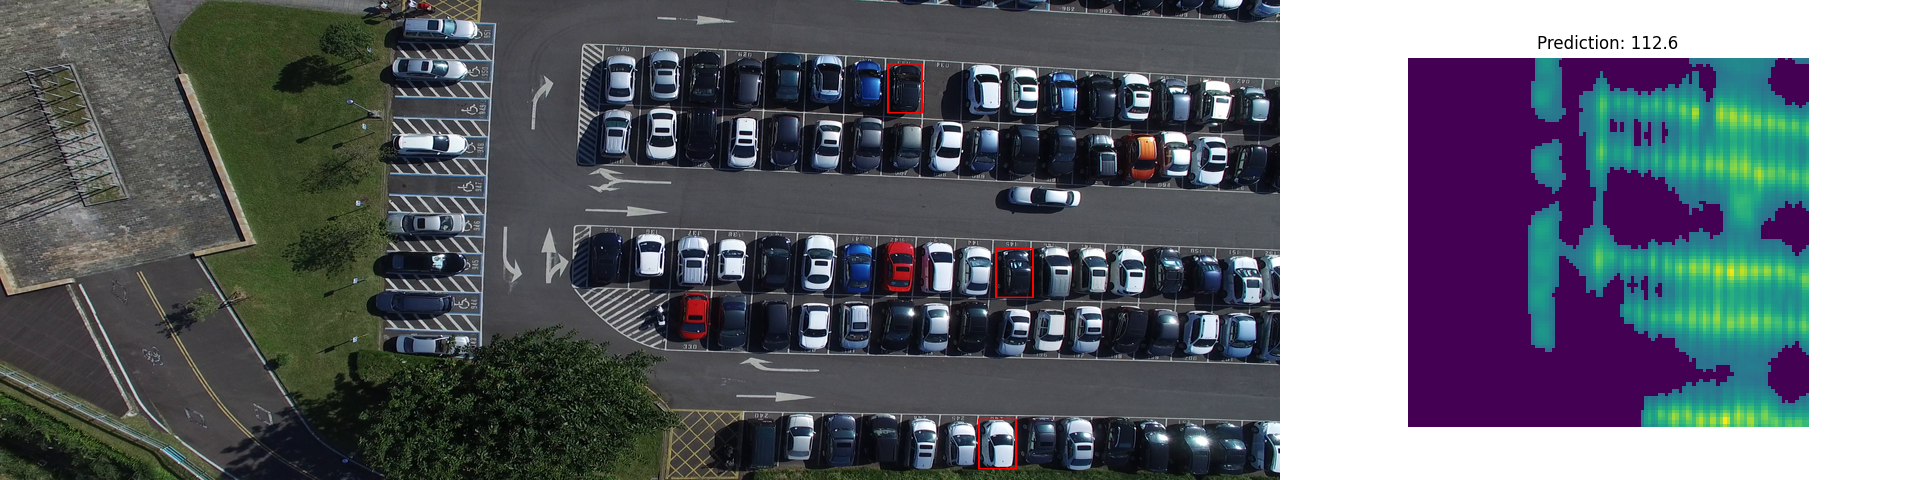

In [5]:
gt_map, pred_map = process_example(filepath, example, model, transform, map_keys, '.', None, config, return_maps=True, gt_count=1)

ex_bboxes = [convert_4corners_to_x1y1x2y2(bbox) for bbox in example['box_examples_coordinates']]
img = draw_bounding_boxes(img, ex_bboxes)
density_map = pred_map.cpu().numpy()
pred = density_map.sum().item()
to_plot_img = combine_pil_and_plot(img, density_map, f"Prediction: {pred:.1f}", other_density_map=None)
to_plot_img